<a href="https://colab.research.google.com/github/GunawanSelayar/deeplearning/blob/main/DaunHerbal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download gunawanselayar/dataset-daun-herbal
!mkdir herbal


In [ ]:
!unzip /content/dataset-daun-herbal.zip -d /content/herbal

In [4]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [6]:
dataset_path = Path(r'/content/herbal/Dataset-Daun-Herbal')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()
     

,image,label
0,/content/herbal/Dataset-Daun-Herbal/daun_panda...,daun_pandan
1,/content/herbal/Dataset-Daun-Herbal/daun_panda...,daun_pandan
2,/content/herbal/Dataset-Daun-Herbal/daun_panda...,daun_pandan
3,/content/herbal/Dataset-Daun-Herbal/daun_panda...,daun_pandan
4,/content/herbal/Dataset-Daun-Herbal/daun_panda...,daun_pandan


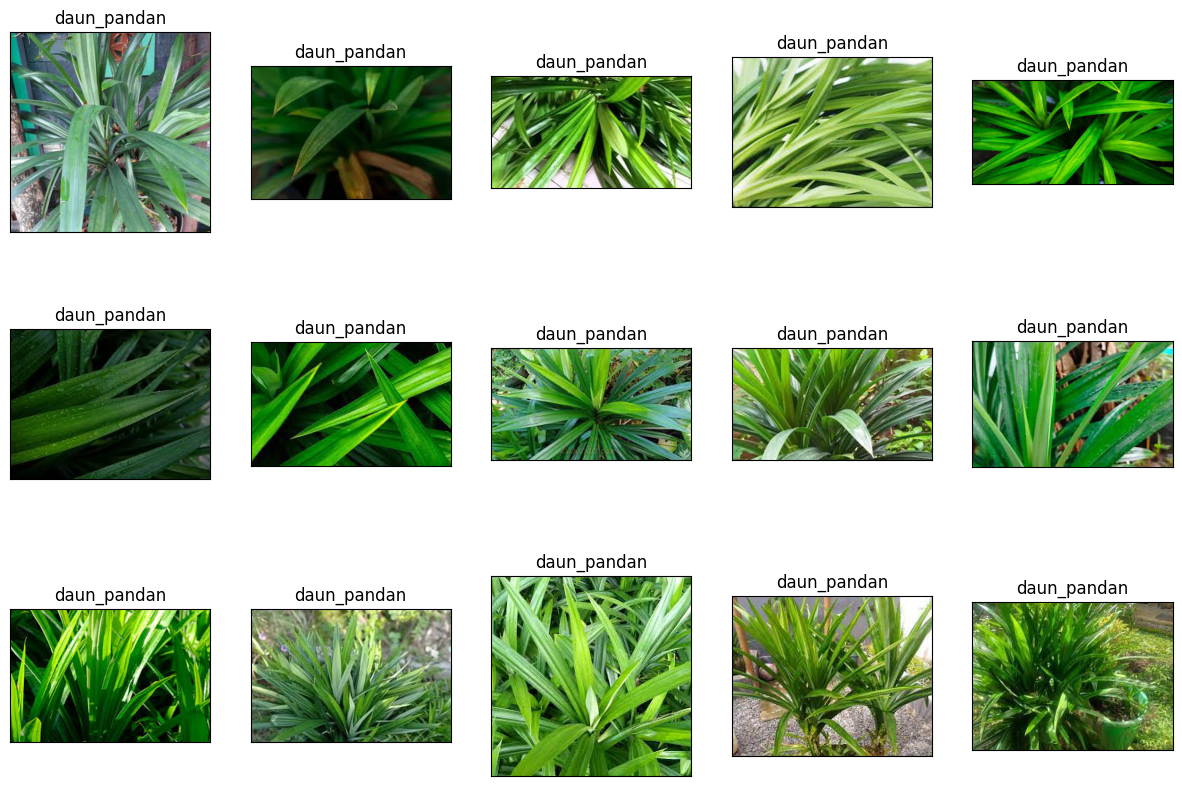

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [9]:
df.label.value_counts()

daun_pandan          100
daun_kumis_kucing    100
daun_pepaya          100
Name: label, dtype: int64

In [10]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

daun_pandan          100
daun_kumis_kucing    100
daun_pepaya          100
Name: label, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [13]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [14]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)
     

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [15]:
input_shape = (200, 200, 3)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [31]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train, batch_size= 64, validation_data=val, epochs=50)

Epoch 1/50
6/6 [==============================] - 5s 394ms/step - loss: 0.3012 - accuracy: 0.8929 - val_loss: 0.6355 - val_accuracy: 0.8333
Epoch 2/50
6/6 [==============================] - 2s 349ms/step - loss: 0.2622 - accuracy: 0.8988 - val_loss: 0.8355 - val_accuracy: 0.7619
Epoch 3/50
6/6 [==============================] - 2s 391ms/step - loss: 0.2844 - accuracy: 0.8869 - val_loss: 1.1887 - val_accuracy: 0.6429
Epoch 4/50
6/6 [==============================] - 3s 418ms/step - loss: 0.2920 - accuracy: 0.8869 - val_loss: 1.1084 - val_accuracy: 0.6429
Epoch 5/50
6/6 [==============================] - 2s 359ms/step - loss: 0.3301 - accuracy: 0.8750 - val_loss: 0.7659 - val_accuracy: 0.6667
Epoch 6/50
6/6 [==============================] - 2s 409ms/step - loss: 0.2721 - accuracy: 0.8929 - val_loss: 0.8652 - val_accuracy: 0.6905
Epoch 7/50
6/6 [==============================] - 2s 397ms/step - loss: 0.2713 - accuracy: 0.8869 - val_loss: 0.8212 - val_accuracy: 0.7381
Epoch 8/50
6/6 [====

In [32]:
model.save('model-1.h5')
     

In [33]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

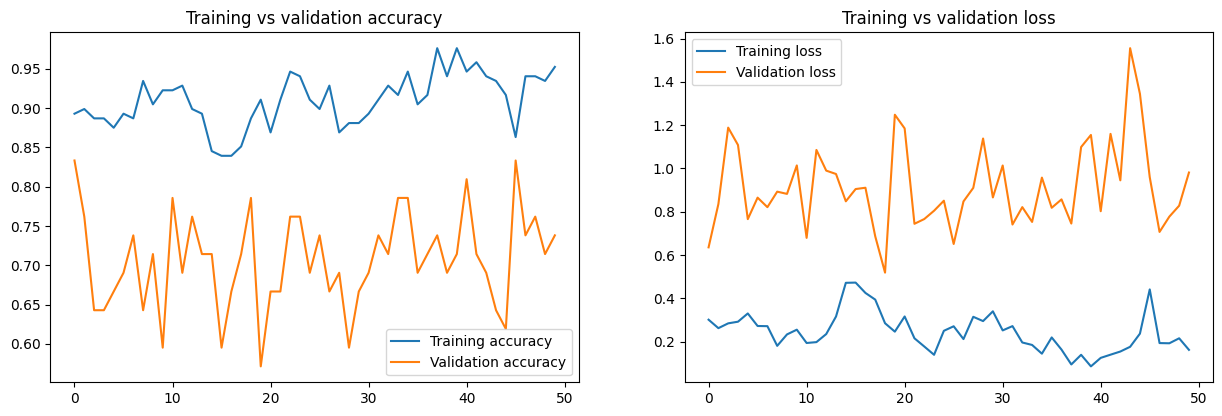

In [35]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [36]:
pred = model.predict(test)

3/3 [==============================] - 1s 264ms/step


In [37]:
pred = np.argmax(pred, axis=1)

In [38]:
labels = train.class_indices

In [39]:
labels

{'daun_kumis_kucing': 0, 'daun_pandan': 1, 'daun_pepaya': 2}

In [40]:
labels = dict((v,k) for k, v in labels.items())

In [41]:
labels

{0: 'daun_kumis_kucing', 1: 'daun_pandan', 2: 'daun_pepaya'}

In [42]:
y_pred = [labels[k] for k in pred]

In [43]:
print(classification_report(x_test.label, y_pred))

                   precision    recall  f1-score   support

daun_kumis_kucing       0.93      0.79      0.85        33
      daun_pandan       0.64      0.76      0.69        33
      daun_pepaya       0.70      0.67      0.68        24

         accuracy                           0.74        90
        macro avg       0.76      0.74      0.74        90
     weighted avg       0.76      0.74      0.75        90



In [44]:
print(confusion_matrix(x_test.label, y_pred))

[[26  6  1]
 [ 2 25  6]
 [ 0  8 16]]


In [45]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 1s 270ms/step - loss: 0.5385 - accuracy: 0.7556
